**Step 1: Get Historical Stock Price Data**

In [1]:
import yfinance as yf   
import pandas as pd  

# Step 1: Download historical data for a specific stock (e.g., Apple)
ticker = yf.Ticker("AAPL")  # "AAPL" is the stock symbol for Apple Inc.

# Step 2: Get 5 years of daily stock data
stock_data = ticker.history(period="5y")

# Step 3: Show the first 5 rows of the data
print(stock_data.head())

                                Open       High        Low      Close  \
Date                                                                    
2020-06-22 00:00:00-04:00  85.381697  87.354996  85.335523  87.211617   
2020-06-23 00:00:00-04:00  88.458279  90.494765  88.037857  89.073112   
2020-06-24 00:00:00-04:00  88.701307  89.622345  87.126552  87.500801   
2020-06-25 00:00:00-04:00  87.656327  88.701298  86.895682  88.662415   
2020-06-26 00:00:00-04:00  88.557936  88.779082  85.789965  85.938210   

                              Volume  Dividends  Stock Splits  
Date                                                           
2020-06-22 00:00:00-04:00  135445200        0.0           0.0  
2020-06-23 00:00:00-04:00  212155600        0.0           0.0  
2020-06-24 00:00:00-04:00  192623200        0.0           0.0  
2020-06-25 00:00:00-04:00  137522400        0.0           0.0  
2020-06-26 00:00:00-04:00  205256800        0.0           0.0  


**Step 2: Add Economic Indicators**

In [2]:
import pandas_datareader.data as web
import datetime

# Step 1: Define the date range (same as your stock data)
start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime.today()

# Step 2: Fetch Consumer Price Index (CPI) - measures inflation
cpi = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)

# Step 3: Fetch Federal Funds Rate (interest rate)
interest_rate = web.DataReader('FEDFUNDS', 'fred', start_date, end_date)

# Step 4: Fetch Unemployment Rate
unemployment = web.DataReader('UNRATE', 'fred', start_date, end_date)

# Step 5: Show the first few rows of each
print("CPI:")
print(cpi.head())

print("\nInterest Rate:")
print(interest_rate.head())

print("\nUnemployment Rate:")
print(unemployment.head())

CPI:
            CPIAUCSL
DATE                
2018-01-01   248.859
2018-02-01   249.529
2018-03-01   249.577
2018-04-01   250.227
2018-05-01   250.792

Interest Rate:
            FEDFUNDS
DATE                
2018-01-01      1.41
2018-02-01      1.42
2018-03-01      1.51
2018-04-01      1.69
2018-05-01      1.70

Unemployment Rate:
            UNRATE
DATE              
2018-01-01     4.0
2018-02-01     4.1
2018-03-01     4.0
2018-04-01     4.0
2018-05-01     3.8


**Step 3: Add Market Sentiment using GenAI Hugging Face**

In [ ]:
from transformers import pipeline

# Step 1: Load a pre-trained sentiment analysis model
sentiment_pipeline = pipeline("sentiment-analysis")

# Step 2: Sample headlines or tweets about the company
news_headlines = [
    "Apple beats earnings expectations with strong iPhone sales",
    "Apple faces antitrust investigation in Europe",
    "Analysts remain optimistic about Apple stock",
    "Apple launches new product lineup with AI features",
    "Supply chain disruptions may impact Apple's production"
]

# Step 3: Run sentiment analysis on each headline
for headline in news_headlines:
    result = sentiment_pipeline(headline)[0]  # Get result as a dictionary
    print(f"'{headline}' → {result['label']} (confidence: {round(result['score'], 2)})")

# Step 4 (Optional): Convert sentiment to numeric score
sentiment_scores = []
for headline in news_headlines:
    result = sentiment_pipeline(headline)[0]
    score = result['score'] if result['label'] == 'POSITIVE' else -result['score']
    sentiment_scores.append(score)

# Let's take the average score (simulate daily sentiment)
daily_sentiment = sum(sentiment_scores) / len(sentiment_scores)
print(f"\nDaily Market Sentiment Score: {round(daily_sentiment, 2)}")


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LENOVO\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased-finetuned-sst-2-english. Caching files wi

'Apple beats earnings expectations with strong iPhone sales' → POSITIVE (confidence: 1.0)
'Apple faces antitrust investigation in Europe' → NEGATIVE (confidence: 0.99)
'Analysts remain optimistic about Apple stock' → NEGATIVE (confidence: 0.98)
'Apple launches new product lineup with AI features' → POSITIVE (confidence: 1.0)
'Supply chain disruptions may impact Apple's production' → NEGATIVE (confidence: 1.0)


**Step 4: Feature Engineering**

In [9]:
# Remove timezone from stock_df index
stock_df.index = stock_df.index.tz_localize(None)

# Already done:
cpi.index = pd.to_datetime(cpi.index)
interest_rate.index = pd.to_datetime(interest_rate.index)
unemployment.index = pd.to_datetime(unemployment.index)

# Now you can join them
combined = stock_df.join(cpi, how='left')\
                   .join(interest_rate, how='left')\
                   .join(unemployment, how='left')

# Rename columns for clarity
combined.columns = ['Close', 'daily_return', 'volatility', 'sentiment', 'CPI', 'Interest_Rate', 'Unemployment']

# Fill missing values (mainly for monthly econ data)
combined.fillna(method='ffill', inplace=True)

# Preview result
print(combined.tail())


                 Close  daily_return  volatility  sentiment     CPI  \
Date                                                                  
2025-06-13  196.449997     -0.013805    0.011399        0.1  320.58   
2025-06-16  198.419998      0.010028    0.011896        0.1  320.58   
2025-06-17  195.639999     -0.014011    0.011987        0.1  320.58   
2025-06-18  196.580002      0.004805    0.012289        0.1  320.58   
2025-06-20  201.000000      0.022484    0.014300        0.1  320.58   

            Interest_Rate  Unemployment  
Date                                     
2025-06-13           4.33           4.2  
2025-06-16           4.33           4.2  
2025-06-17           4.33           4.2  
2025-06-18           4.33           4.2  
2025-06-20           4.33           4.2  


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_3744\3086680876.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined.fillna(method='ffill', inplace=True)


**Step 5: Predict Stock Price using Prophet**

13:28:27 - cmdstanpy - INFO - Chain [1] start processing
13:28:28 - cmdstanpy - INFO - Chain [1] done processing


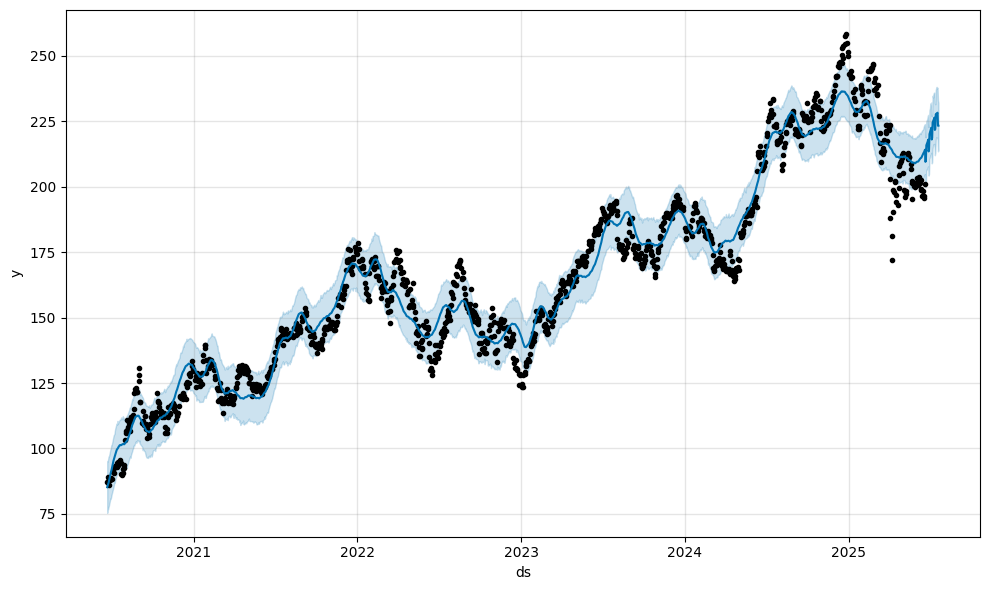

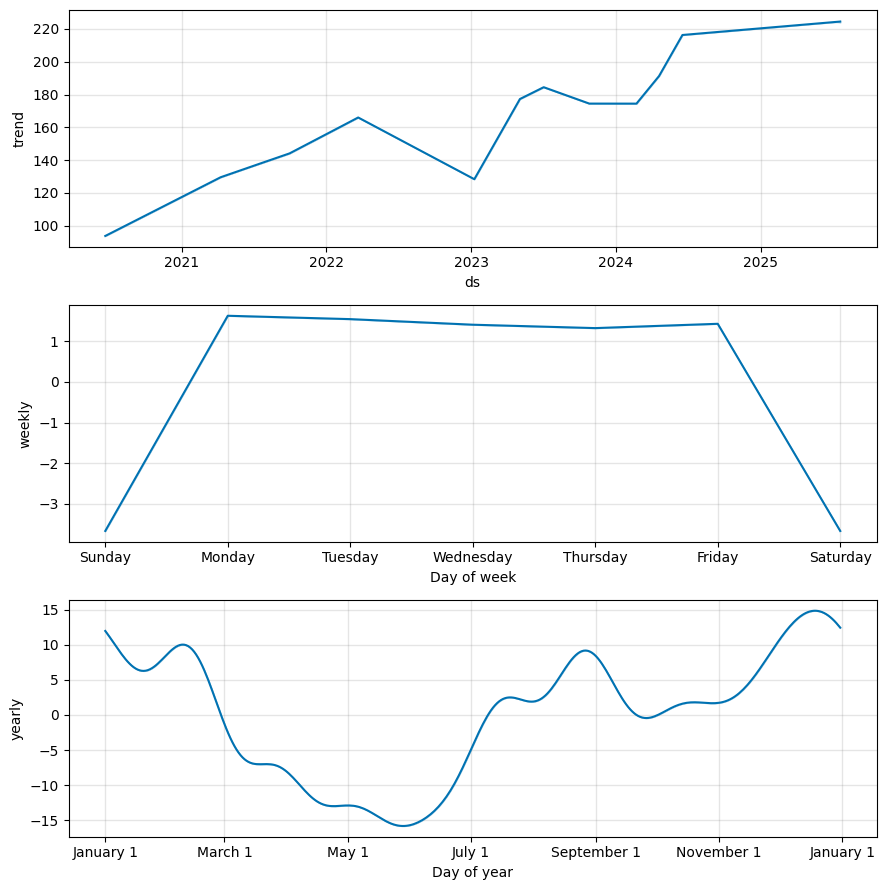

In [18]:
from prophet import Prophet

# Prepare the data for Prophet
prophet_df = combined.reset_index()[['Date', 'Close']]
prophet_df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Drop any missing values (just in case)
prophet_df.dropna(inplace=True)
# Create the model
model = Prophet()

# Train the model on historical data
model.fit(prophet_df)

# Create a dataframe for future dates
future = model.make_future_dataframe(periods=30)

# Predict future values
forecast = model.predict(future)

# Show forecasted values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig = model.plot(forecast)
fig2 = model.plot_components(forecast)
forecast[['ds', 'yhat']].to_csv("apple_stock_forecast.csv", index=False)


**Step 6: Predict Stock Price Using Deep Learning (Darts - LSTM Model)**

In [ ]:
from darts import TimeSeries
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler
import pandas as pd
import numpy as np



# Ensure Date is datetime and set as index
combined.reset_index(inplace=True)
combined['Date'] = pd.to_datetime(combined['Date'])
combined.set_index('Date', inplace=True)

# Fix: Tell Darts to fill missing dates and infer frequency
target_series = TimeSeries.from_series(
    combined['Close'],
    fill_missing_dates=True,
    freq='D'  # 'D' means daily
)

covariate_series = TimeSeries.from_dataframe(
    combined[['daily_return', 'volatility', 'sentiment', 'CPI', 'Interest_Rate', 'Unemployment']],
    fill_missing_dates=True,
    freq='D'  # same fix
)

# Normalize both target and covariates
scaler_target = Scaler()
scaler_covariates = Scaler()

target_scaled = scaler_target.fit_transform(target_series)
covariates_scaled = scaler_covariates.fit_transform(covariate_series)

train_target, val_target = target_scaled.split_before(0.8)
train_cov, val_cov = covariates_scaled.split_before(0.8)


model = RNNModel(
    model='LSTM',
    input_chunk_length=30,   # Lookback window
    output_chunk_length=7,   # Predict next 7 days
    n_epochs=100,
    random_state=42,
    training_length=50,
    dropout=0.2,
    batch_size=32,
    optimizer_kwargs={'lr': 1e-3}
)

# Train the model
model.fit(
    series=train_target,
    verbose=True
)

prediction = model.predict(
    n=30,  # Predict 30 days into the future
)

# Reverse scaling
prediction = scaler_target.inverse_transform(prediction)


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


**Step 7: Backtesting (Darts LSTM)**

In [ ]:
from darts.metrics import mape

# Run backtest with LSTM model
backtest = model.historical_forecasts(
    series=target_scaled,
    past_covariates=covariates_scaled,
    start=0.8,                  # Start backtesting from 80% of data
    forecast_horizon=7,         # Predict next 7 days at each step
    stride=7,                   # Move forward in weekly steps
    retrain=False,              # Set True to retrain each time (slower)
    verbose=True
)

# Compute error
error = mape(target_scaled, backtest)
print(f"MAPE (Mean Absolute Percentage Error): {round(error, 2)}%")
from sklearn.metrics import mean_absolute_error

# Prophet: use last N values (align with test set)
actual = prophet_df['y'].tail(30).values
predicted = forecast['yhat'].tail(30).values

mae = mean_absolute_error(actual, predicted)
print(f"Prophet MAE: {mae:.2f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.89it/s]
MAPE (Mean Absolute Percentage Error): nan%
Prophet MAE: 18.65


**Step 8: Use Langchain + LlamaIndex to Generate Insights**

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

from llama_index.llms.groq import Groq
from langchain.llms.base import LLM

llm = Groq(
    model="llama3-8b-8192",  # Or another model you prefer
    api_key=os.getenv("GROQ_API_KEY"),
    temperature=0.3
)

from llama_index.core import Document

# Example: convert a few rows of your combined dataset
data_sample = combined.tail(10)  # last 10 days

docs = []
for date, row in data_sample.iterrows():
    text = f"""On {date.date()}, Apple stock closed at ${row['Close']:.2f}.
    Daily return: {row['daily_return']:.4f}
    Volatility: {row['volatility']:.4f}
    Sentiment: {row['sentiment']:.2f}
    CPI: {row['CPI']:.2f}
    Interest Rate: {row['Interest_Rate']:.2f}
    Unemployment: {row['Unemployment']:.2f}"""
    
    docs.append(Document(text=text))

from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import VectorStoreIndex, Settings

# Hugging Face embedding model
embed_model = HuggingFaceEmbedding(model_name="all-MiniLM-L6-v2")

# Configure LlamaIndex to use Groq + HuggingFace
Settings.llm = llm
Settings.embed_model = embed_model
# Build the index with updated settings
index = VectorStoreIndex.from_documents(docs)
query_engine = index.as_query_engine()
response = query_engine.query("Why did the model predict a drop in Apple's stock?")
print(response)
